# Using Variational Autoencoder to Generate Digital Numbers

Variational Autoencoders (VAEs) are very popular approaches to unsupervised learning of complicated distributions. In this example, we are going to use VAE to generate digital numbers.

![Standard Autoencoder](./standard_autoencoder.jpg)

In standard Autoencoder, we have an encoder network that takes in the original image and encode it into a vector of latent variables and a decoder network that takes in the latent vector and output an generated image that we hope to look similar to the original image.

![vae](./vae.jpg)

In VAE, we constrain the latent variable to be unit gaussian, so that we can sample latent variables from a unit gaussian distribution, then use the decoder network to generate images.

So, we get the architecture above. Instead of generate the latent variables directly, the encoder network output a mean vector and a variance (or log-variance) vector, and the decoder takes the sampled latent vector to generate the output image. And we add penalty on the latent distribution's KL Divergence to a unit gaussian distribution.

## Define the Model

In [1]:
# a bit of setup
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.dataset import mnist
import datetime as dt
from bigdl.util.common import *

IMAGE_SIZE = 784
IMAGE_ROWS = 28
IMAGE_COLS = 28
IMAGE_CHANNELS = 1




We are going to use a simple cnn network as our encoder and decoder. In decoder, we use SpatialFullConvolution (aka deconvolution or convolution transpose) layer to upsample the image to the original resolution.

In [2]:
def get_encoder_cnn(latent_size):
    input0 = Input()
    view = View([IMAGE_CHANNELS, IMAGE_ROWS, IMAGE_COLS])(input0)
    #CONV
    conv1 = SpatialConvolution(IMAGE_CHANNELS, 16, 5, 5, 2, 2, 2, 2)(view) # 14 * 14 * 16
    relu1 = LeakyReLU()(conv1)
    conv2 = SpatialConvolution(16, 32, 5, 5, 2, 2, 2, 2)(relu1) # 7 * 7 * 32
    relu2 = LeakyReLU()(conv2) 
    
    # fully connected to output mean vector and log-variance vector
    reshape = Reshape([7*7*32])(relu2)
    mean = Linear(7*7*32, latent_size)(reshape)
    log_var = Linear(7*7*32, latent_size)(reshape)
    
    model = Model([input0], [mean, log_var])
    return model

In [3]:
def get_decoder_cnn(latent_size):
    input0 = Input()
    linear0 = Linear(latent_size, 7*7*32)(input0)
    relu0 = ReLU()(linear0)
    reshape0 = Reshape([32, 7, 7])(relu0)
    
    # deconv layer
    deconv1 = SpatialFullConvolution(32, 16, 5, 5, 2, 2, 2, 2, 1, 1)(reshape0)
    relu1 = ReLU()(deconv1)
    deconv2 = SpatialFullConvolution(16, 1, 5, 5, 2, 2, 2, 2, 1, 1)(relu1)
    view = View([IMAGE_ROWS, IMAGE_COLS,1])(deconv2)
    output = Sigmoid()(view)
    
    model = Model([input0], [output])
    return model

In [4]:
def get_autoencoder_cnn(latent_size):
    input0 = Input()
    encoder = get_encoder_cnn(latent_size)(input0)
    
    sample = GaussianSampler()(encoder)
    decoder_model = get_decoder_cnn(latent_size)
    decoder = decoder_model(sample)

    model = Model([input0], [encoder, decoder])
    return model, decoder_model

In [5]:
init_engine()
model, decoder = get_autoencoder_cnn(2)

creating: createInput
creating: createInput
creating: createView
creating: createSpatialConvolution
creating: createLeakyReLU
creating: createSpatialConvolution
creating: createLeakyReLU
creating: createReshape
creating: createLinear
creating: createLinear
creating: createModel
creating: createGaussianSampler
creating: createInput
creating: createLinear
creating: createReLU
creating: createReshape
creating: createSpatialFullConvolution
creating: createReLU
creating: createSpatialFullConvolution
creating: createView
creating: createSigmoid
creating: createModel
creating: createModel


## Get the MNIST Dataset

In [6]:
def get_mnist(sc, mnist_path):
    (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
    
    rdd_train_images = sc.parallelize(train_images)

    rdd_train_sample = rdd_train_images.map(lambda img:
                                        Sample.from_ndarray(
                                        (img > 128) * 1.0,
                                        [(img > 128) * 1.0, (img > 128) * 1.0]))
    return rdd_train_sample

In [7]:
mnist_path = "datasets/mnist" # please replace this
from pyspark import SparkContext 
sc =SparkContext.getOrCreate() 
train_data = get_mnist(sc, mnist_path)

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')


## Define our Training Objective

The `size_average` parameter in `BCECriterion` should be `False`, because when `size_average` is `True`, the negative_log_likelyhood computed in `BCECriterion` is average over each observations **as well as dimensions**, while in the `KLDCriterion` the KL-Divergence is **sumed over each observations**, the loss woule be wrong.

In [8]:
criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 1.0)
criterion.add(BCECriterion(size_average=False), 1.0)

creating: createParallelCriterion
creating: createKLDCriterion
creating: createBCECriterion


## Setup the Optimizer

In [9]:
batch_size = 100


# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=train_data,
    criterion=criterion,
    optim_method=Adam(0.001),
    end_trigger=MaxEpoch(15),
    batch_size=batch_size)


app_name='vae-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)


optimizer.set_train_summary(train_summary)

print "saving logs to ",app_name

creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createTrainSummary
saving logs to  vae-20180509-140247


## Start Training

This step may takes a while depending on your system

In [10]:
redire_spark_logs()
show_bigdl_info_logs()
trained_model = optimizer.optimize()


Let's show the leaning curve.

In [11]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


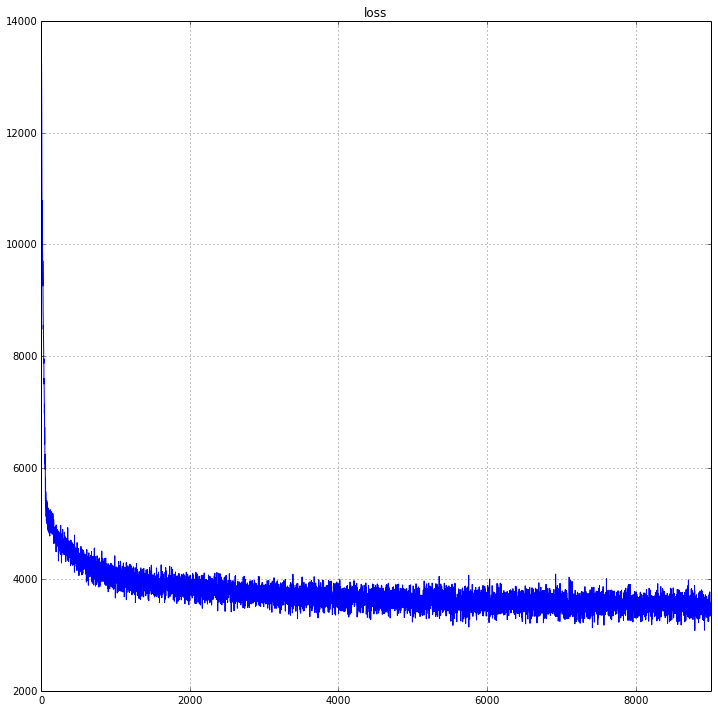

In [12]:
loss = np.array(train_summary.read_scalar("Loss"))

plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

You can also open tensorboard in /tmp/bigdl_summaries to see this curve.

## Sample Some Images from the Decoder

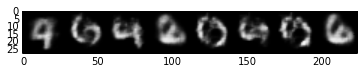

In [15]:
from matplotlib.pyplot import imshow
img = np.column_stack([decoder.forward(np.random.randn(2)).reshape(28,28) for s in range(8)])
imshow(img, cmap='gray')

## Explore the Latent Space

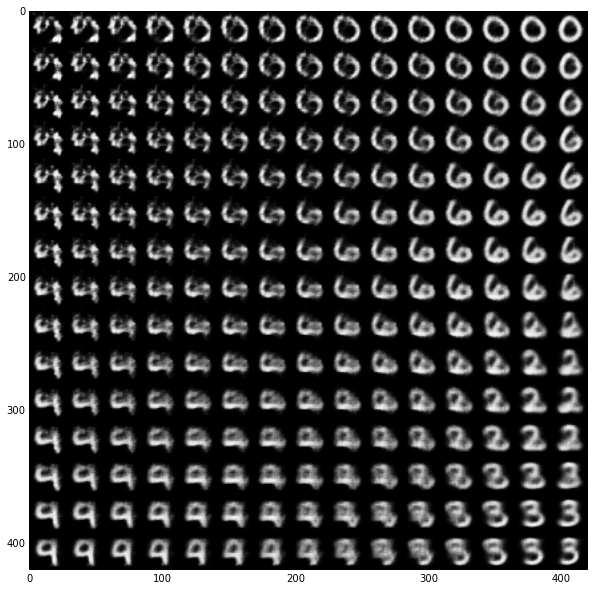

In [17]:
# This code snippet references this keras example (https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py)
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.forward(z_sample)
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()